# Importing Necessary Libraries and Datasets

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme(style="whitegrid")

# Load datasets
print("Loading Necessary Datasets")

revenue_df = pd.read_csv("Revenue data.csv")
hp_df = pd.read_csv("Total_HP_data - Sayfa1.csv")
usage_df = pd.read_csv("useRatedata Generalized.csv")

Loading Necessary Datasets


# Data Cleaning And Patch Mapping

In [34]:
# Clean Revenue
revenue_df['Revenue (Million USD)'] = revenue_df['Revenue (Million USD)'].astype(str).str.replace('~', '').astype(float)
revenue_df['Date'] = pd.to_datetime(revenue_df['Date'])

# Clean Usage
usage_df['Generalized'] = usage_df['Generalized'].astype(str).str.replace(',', '.').astype(float)

# Clean HP
hp_df['Total'] = pd.to_numeric(hp_df['Total'], errors='coerce')
hp_df['patch_clean'] = hp_df['patch'].str.replace('_A', '').str.replace('_B', '')
hp_agg = hp_df.groupby('patch_clean')['Total'].mean().reset_index().rename(columns={'patch_clean': 'patch'})

patch_dates = {
    '3_0': ['2022-09'], '3_1': ['2022-10'], '3_2': ['2022-11'], '3_3': ['2022-12'],
    '3_4': ['2023-01', '2023-02'], '3_5': ['2023-03'], '3_6': ['2023-04', '2023-05'],
    '3_7': ['2023-06'], '3_8': ['2023-07', '2023-08'],
    '4_0': ['2023-09'], '4_1': ['2023-10'], '4_2': ['2023-11', '2023-12'],
    '4_3': ['2024-01'], '4_4': ['2024-02', '2024-03'], '4_5': ['2024-04'],
    '4_6': ['2024-05', '2024-06'], '4_7': ['2024-07'], '4_8': ['2024-08'],
    '5_0': ['2024-09'], '5_1': ['2024-10', '2024-11'], '5_2': ['2024-12'],
    '5_3': ['2025-01'], '5_4': ['2025-02', '2025-03'], '5_5': ['2025-04']
}
month_to_patch = {m: p for p, months in patch_dates.items() for m in months}

revenue_df['patch'] = revenue_df['Date'].dt.strftime('%Y-%m').map(month_to_patch)
rev_per_patch = revenue_df.dropna(subset=['patch']).groupby('patch')['Revenue (Million USD)'].mean().reset_index()

# Preparing Datasets

In [35]:
def get_patch_val(p):
    parts = p.split('_')
    return float(parts[0]) + float(parts[1])/10.0

usage_per_patch = usage_df.groupby('patch')['Generalized'].mean().reset_index()
usage_per_patch.columns = ['patch', 'Usage_Mean']

# Merge Everything into one Master DataFrame
# Using inner merge to ensure we have data for all variables for the correlation matrix
master_df = hp_agg.merge(rev_per_patch, on='patch', how='inner') \
                  .merge(usage_per_patch, on='patch', how='inner')

master_df['patch_val'] = master_df['patch'].apply(get_patch_val)
master_df = master_df[(master_df['patch_val'] >= 3.0) & (master_df['patch_val'] <= 5.5)].sort_values('patch_val')
master_df['Time_Index'] = np.arange(len(master_df))

print("All Datasets are Prepared")

All Datasets are Prepared


# Calculating Partial Correlation

In [36]:
# We calculate residuals for ALL key metrics to remove the "Time" trend
metrics = ['Usage_Mean', 'Total', 'Revenue (Million USD)']
resid_cols = []

for col in metrics:
    slope, intercept, _, _, _ = stats.linregress(master_df['Time_Index'], master_df[col])
    # Residual = Actual - Predicted Trend
    master_df[f'{col}_Resid'] = master_df[col] - (slope * master_df['Time_Index'] + intercept)
    resid_cols.append(f'{col}_Resid')

# Plotting Datasets

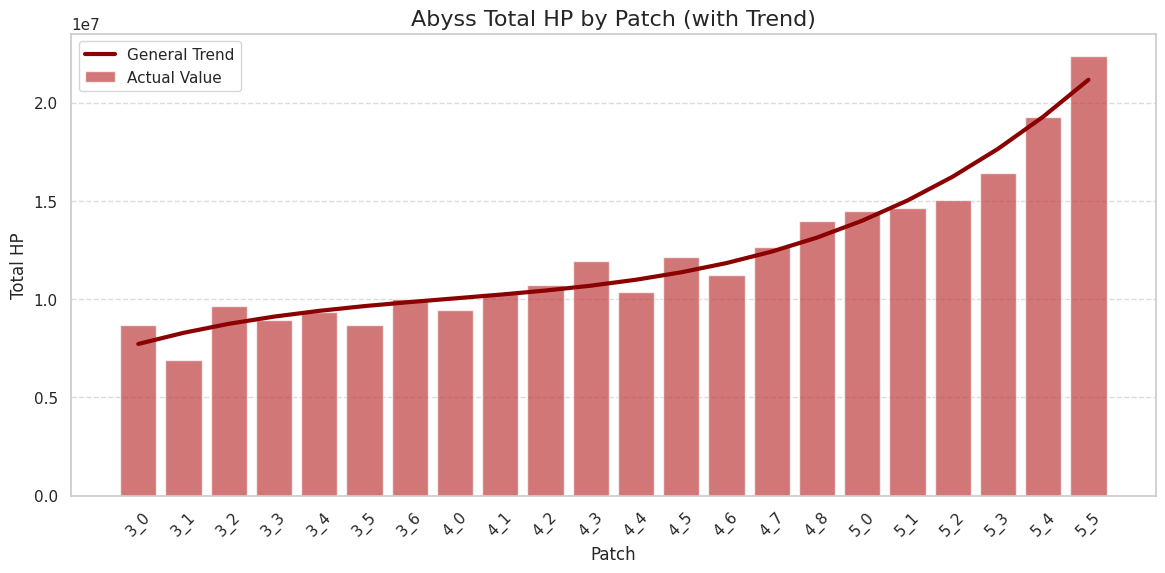

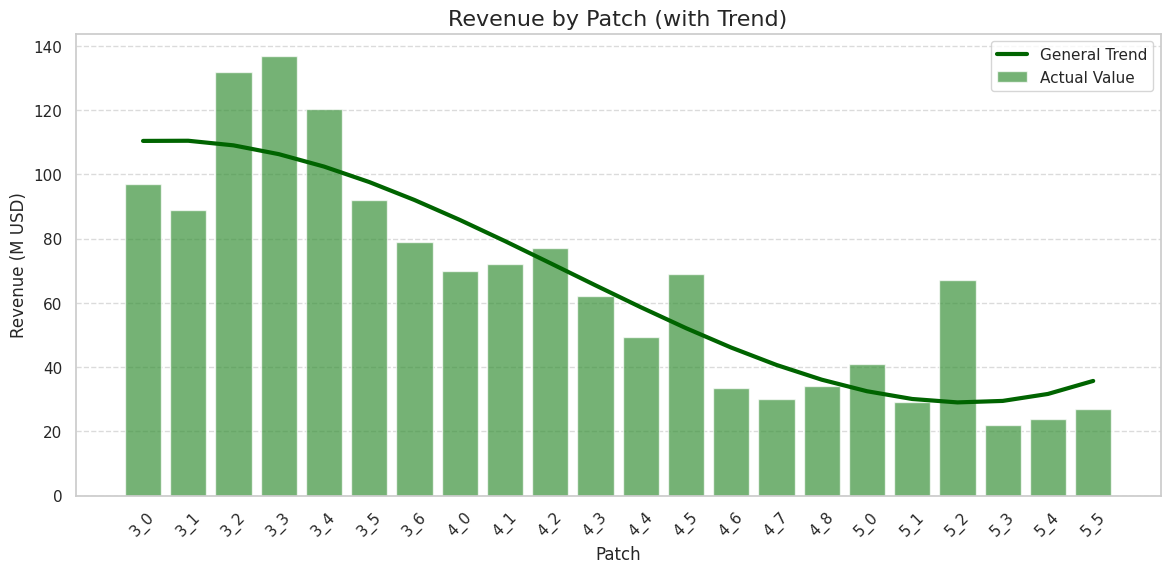

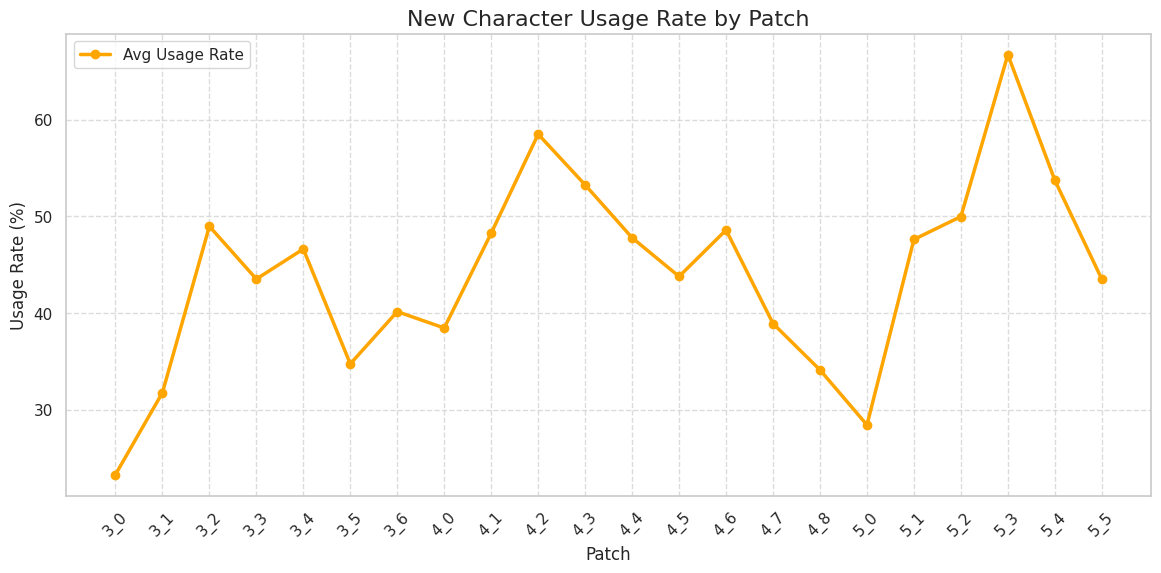

In [37]:
def plot_with_trend(df, x_col, y_col, title, ylabel, bar_color, line_color, filename):
    plt.figure(figsize=(14, 6))
    sns.barplot(x=x_col, y=y_col, data=df, color=bar_color, alpha=0.7, label='Actual Value')

    mask = ~np.isnan(df[y_col])
    if mask.sum() > 3:
        z = np.polyfit(df.loc[mask, 'Time_Index'], df.loc[mask, y_col], 3)
        p = np.poly1d(z)
        plt.plot(df['Time_Index'], p(df['Time_Index']), color=line_color, linewidth=3, label='General Trend')

    plt.title(title, fontsize=16)
    plt.xlabel('Patch', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.savefig(filename, dpi=300)
    plt.show()

# Graph 1: HP
plot_with_trend(master_df, 'patch', 'Total', 'Abyss Total HP by Patch (with Trend)', 'Total HP', 'tab:red', 'darkred', 'Graph_1_HP.png')

# Graph 2: Revenue
plot_with_trend(master_df, 'patch', 'Revenue (Million USD)', 'Revenue by Patch (with Trend)', 'Revenue (M USD)', 'tab:green', 'darkgreen', 'Graph_2_Revenue.png')

#Graph 3: Usage Rate
plt.figure(figsize=(14, 6))
plt.plot(master_df['patch'], master_df['Usage_Mean'], marker='o', color='orange', linewidth=2.5, label='Avg Usage Rate')
plt.title('New Character Usage Rate by Patch', fontsize=16)
plt.xlabel('Patch', fontsize=12)
plt.ylabel('Usage Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Graph_3_Usage_Line.png', dpi=300)
plt.show()

# Plotting The Correlation

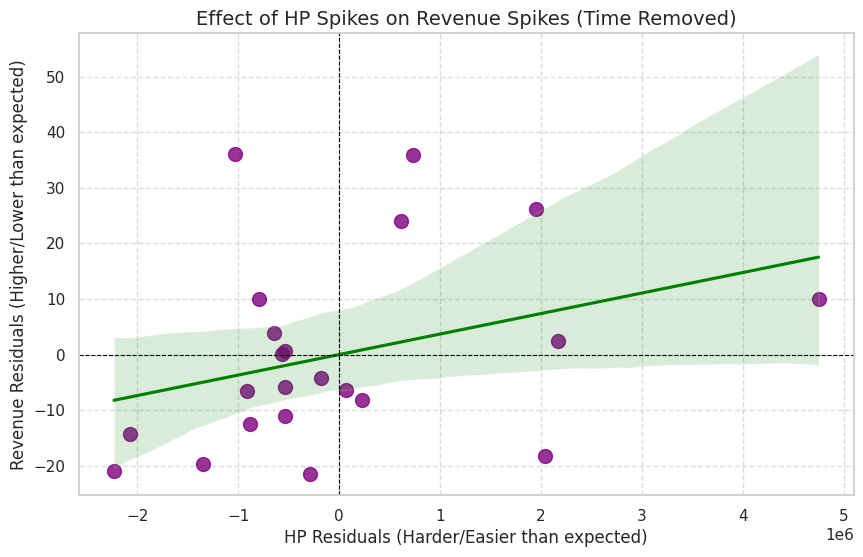

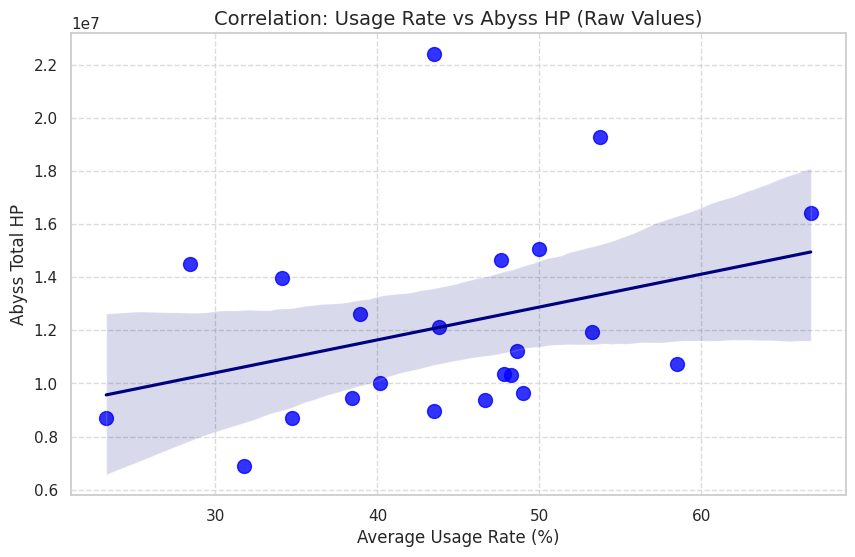

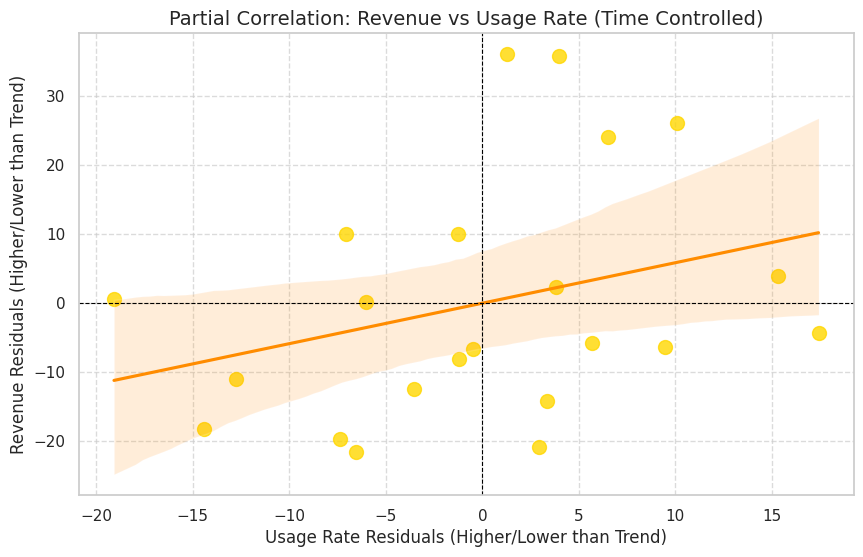

In [38]:
# Graph 4: Scatter of Residuals (HP vs Revenue)
plt.figure(figsize=(10, 6))
sns.regplot(x='Total_Resid', y='Revenue (Million USD)_Resid', data=master_df,
            scatter_kws={'s':100, 'color':'purple'}, line_kws={'color':'green'})
plt.title('Effect of HP Spikes on Revenue Spikes (Time Removed)', fontsize=14)
plt.xlabel('HP Residuals (Harder/Easier than expected)', fontsize=12)
plt.ylabel('Revenue Residuals (Higher/Lower than expected)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Graph_4_Partial_Corr_Scatter.png', dpi=300)
plt.show()

# Graph 5: HP vs Usage Rate (RAW Correlation)
plt.figure(figsize=(10, 6))
sns.regplot(x='Usage_Mean', y='Total', data=master_df,
            scatter_kws={'s':100, 'color':'blue'}, line_kws={'color':'navy'})
plt.title('Correlation: Usage Rate vs Abyss HP (Raw Values)', fontsize=14)
plt.xlabel('Average Usage Rate (%)', fontsize=12)
plt.ylabel('Abyss Total HP', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Graph_6_HP_Usage_Raw.png', dpi=300)
plt.show()

# Graph 6: Revenue vs Usage Rate (PARTIAL Correlation)
plt.figure(figsize=(10, 6))
sns.regplot(x='Usage_Mean_Resid', y='Revenue (Million USD)_Resid', data=master_df,
            scatter_kws={'s':100, 'color':'gold'}, line_kws={'color':'darkorange'})
plt.title('Partial Correlation: Revenue vs Usage Rate (Time Controlled)', fontsize=14)
plt.xlabel('Usage Rate Residuals (Higher/Lower than Trend)', fontsize=12)
plt.ylabel('Revenue Residuals (Higher/Lower than Trend)', fontsize=12)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('Graph_7_Rev_Usage_Partial.png', dpi=300)
plt.show()

# Creating Correlation Matrix

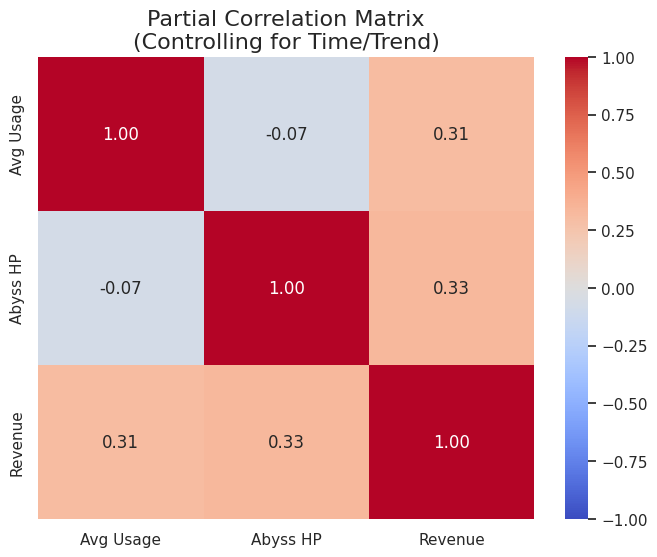

In [39]:
#Graph 7: Partial Correlation Matrix
# We compute correlation on the RESIDUAL columns only to control for time
resid_corr_matrix = master_df[resid_cols].corr()

# Rename columns for cleaner display
clean_labels = ['Avg Usage', 'Abyss HP', 'Revenue']
resid_corr_matrix.columns = clean_labels
resid_corr_matrix.index = clean_labels

plt.figure(figsize=(8, 6))
sns.heatmap(resid_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f",
            xticklabels=clean_labels, yticklabels=clean_labels)
plt.title('Partial Correlation Matrix\n(Controlling for Time/Trend)', fontsize=16)
plt.savefig('Graph_5_Partial_Corr_Matrix.png', dpi=300)
plt.show()

# Executing Hypothesis Testing

In [40]:
raw_hp_usage_corr = master_df['Usage_Mean'].corr(master_df['Total'])
partial_rev_usage_corr = master_df['Usage_Mean_Resid'].corr(master_df['Revenue (Million USD)_Resid'])
partial_hp_rev_corr = master_df['Total_Resid'].corr(master_df['Revenue (Million USD)_Resid'])

print("\n" + "="*60)
print("             Hypothesis Testing Output")
print("="*60)

print(f"\n1. Usage Rate vs HP (Raw Correlation): {raw_hp_usage_corr:.4f}")
print("   (Interpretation: Does high HP generally happen alongside high Usage?) (Weak positive correlation)")

print(f"\n2. Revenue vs Usage Rate (Partial Correlation): {partial_rev_usage_corr:.4f}")
print("   (Interpretation: Do high-usage patches make more money, ignoring game growth?) (Weak positive correlation)")

print(f"\n3. HP vs Revenue (Partial Correlation): {partial_hp_rev_corr:.4f}")
print("   (Interpretation: Do harder patches make more money, ignoring game growth?) (Weak positive correlation)")


             Hypothesis Testing Output

1. Usage Rate vs HP (Raw Correlation): 0.3318
   (Interpretation: Does high HP generally happen alongside high Usage?) (Weak positive correlation)

2. Revenue vs Usage Rate (Partial Correlation): 0.3106
   (Interpretation: Do high-usage patches make more money, ignoring game growth?) (Weak positive correlation)

3. HP vs Revenue (Partial Correlation): 0.3344
   (Interpretation: Do harder patches make more money, ignoring game growth?) (Weak positive correlation)
